In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from keras.utils import plot_model
import numpy as np
import tensorflow as tf
from keras.utils import plot_model
from SpectralLayer import Spectral
from tensorflow.keras.layers import Dense

from entropyLayer import *
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

flat_train = np.reshape(x_train, [x_train.shape[0], 28 * 28])
flat_test = np.reshape(x_test, [x_test.shape[0], 28 * 28])

In [193]:
spectral_config={
    'is_base_trainable' : False,
    'is_diag_start_trainable' : True,
    'is_diag_end_trainable' : False,
    'use_bias' : False
}
N=[20,80,100,500,800,1000,1500,2000]
epochs = 20
batch_size=200
learning_rate=0.003

In [200]:
def get_accuracy(name_file="",i=1):
    with open(f"Data{i}/{name_file}.csv", "r") as f:
        data=pd.read_csv(f, sep=",", header=0)
    try:
        data.set_index('N', inplace=True)
    except:
        data.set_index('S', inplace=True)
    return data

In [197]:
def extract_accuracy_and_save(name_file=None,i=1):
    accuracy:Dict[int,pd.DataFrame]=dict()
    num=0
    N = [20, 80, 100, 500, 800, 1000, 1500, 2000]
    S=[i for i in range(1,6)]
    while 0 <= num < 5:
        iteration = 0
        while iteration < 8:
            with open(f"Data{i}/{name_file}/accuracy{num}.txt", "r") as f:
                accuracy[num]=pd.read_csv(f, sep=" ", header=None)
                accuracy[num].rename(columns={0:f"r{num+1}"},inplace=True)
            iteration += 1
        num+=1
    data = pd.concat([accuracy[0],accuracy[1],accuracy[2],accuracy[3],accuracy[4]], axis=1)
    try:
        data['N']=N
        data.set_index('N', inplace=True)
    except:
        data['S']=S
        data.set_index('S', inplace=True)
    data["vmax"]=data.apply(max,axis=1)
    data["vmin"]=data.apply(min,axis=1)
    data["vmean"]=data.apply(np.mean,axis=1)
    data["sigma"]= data[["r1",'r2',"r3","r4","r5"]].std(axis=1)
    data.to_csv(f"Data{i}/{name_file}/{name_file}.csv", header=True, index=True)
    return data

# Direct space

In [201]:
data=get_accuracy(name_file="Reference",i=0)
data["q1"]=data[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data["q2"]=data[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data["med"]=data[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.9232,0.9220,0.9211,0.9216,0.9234,0.9234,0.9211,0.922257,0.001004,0.9216,0.9232,0.9220
80,0.9238,0.9242,0.9207,0.9181,0.9197,0.9242,0.9181,0.921257,0.002637,0.9197,0.9238,0.9207
100,0.9228,0.9216,0.9185,0.9173,0.9240,0.9240,0.9173,0.920786,0.002847,0.9185,0.9228,0.9216
500,0.9179,0.9198,0.9130,0.9189,0.9200,0.9200,0.9130,0.917514,0.002874,0.9179,0.9198,0.9189
800,0.9046,0.9137,0.9173,0.9188,0.9197,0.9197,0.9046,0.914057,0.006154,0.9137,0.9188,0.9173
1000,0.9170,0.9193,0.9124,0.9137,0.9148,0.9193,0.9124,0.915557,0.002739,0.9137,0.9170,0.9148
1500,0.9161,0.9149,0.9146,0.9117,0.9144,0.9161,0.9117,0.914214,0.001616,0.9144,0.9149,0.9146
2000,0.9157,0.9114,0.9181,0.9136,0.9174,0.9181,0.9114,0.915100,0.002761,0.9136,0.9174,0.9157


# Model spectral

In [202]:
data1=get_accuracy(name_file="spectral",i=0)
data1["q1"]=data1[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data1["q2"]=data1[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data1["med"]=data1[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data1

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.3008,0.3651,0.3598,0.3363,0.3664,0.3664,0.3008,0.342229,0.027875,0.3363,0.3651,0.3598
80,0.5515,0.5648,0.5434,0.5638,0.5627,0.5648,0.5434,0.556343,0.009414,0.5515,0.5638,0.5627
100,0.5934,0.5844,0.5893,0.5840,0.5238,0.5934,0.5238,0.570300,0.028870,0.5840,0.5893,0.5844
500,0.8371,0.8521,0.8537,0.8412,0.8470,0.8537,0.8371,0.845986,0.007062,0.8412,0.8521,0.8470
800,0.8769,0.8727,0.8793,0.8722,0.8756,0.8793,0.8722,0.875457,0.002959,0.8727,0.8769,0.8756
1000,0.8838,0.8815,0.8777,0.8728,0.8792,0.8838,0.8728,0.878800,0.004167,0.8777,0.8815,0.8792
1500,0.8923,0.8894,0.8920,0.8961,0.8934,0.8961,0.8894,0.892671,0.002428,0.8920,0.8934,0.8923
2000,0.8981,0.8984,0.8972,0.8926,0.8977,0.8984,0.8926,0.896429,0.002391,0.8972,0.8981,0.8977


# Direct space constraint

In [203]:
data2=get_accuracy(name_file="EDC",i=0)
data2["q1"]=data2[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data2["q2"]=data2[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data2["med"]=data2[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data2

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.2990,0.2216,0.2364,0.1908,0.2514,0.2990,0.1908,0.241286,0.039947,0.2216,0.2514,0.2364
80,0.3953,0.3896,0.3789,0.3574,0.3901,0.3953,0.3574,0.380571,0.015122,0.3789,0.3901,0.3896
100,0.3850,0.3531,0.3060,0.3392,0.3179,0.3850,0.3060,0.341743,0.030989,0.3179,0.3531,0.3392
500,0.7178,0.7302,0.7253,0.7149,0.7005,0.7302,0.7005,0.717057,0.011376,0.7149,0.7253,0.7178
800,0.7809,0.7943,0.7847,0.7940,0.7824,0.7943,0.7809,0.787357,0.006435,0.7824,0.7940,0.7847
1000,0.8101,0.8009,0.8239,0.8303,0.8151,0.8303,0.8009,0.815929,0.011516,0.8101,0.8239,0.8151
1500,0.8563,0.8544,0.8577,0.8595,0.8534,0.8595,0.8534,0.856314,0.002460,0.8544,0.8577,0.8563
2000,0.8790,0.8740,0.8731,0.8793,0.8712,0.8793,0.8712,0.875300,0.003641,0.8731,0.8790,0.8740


## Not activity

In [204]:
data3=get_accuracy(name_file="EDC2",i=0)
data3["q1"]=data3[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data3["q2"]=data3[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data3["med"]=data3[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data3

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.1204,0.1304,0.1003,0.0934,0.1150,0.1304,0.0934,0.111900,0.015008,0.1003,0.1204,0.1150
80,0.1464,0.2149,0.1061,0.1385,0.0606,0.2149,0.0606,0.134571,0.056750,0.1061,0.1464,0.1385
100,0.1574,0.0980,0.1280,0.1297,0.0975,0.1574,0.0975,0.123643,0.025123,0.0980,0.1297,0.1280
500,0.0940,0.0937,0.1139,0.1260,0.1178,0.1260,0.0937,0.109300,0.014573,0.0940,0.1178,0.1139
800,0.1019,0.1271,0.0914,0.1323,0.0982,0.1323,0.0914,0.110657,0.018305,0.0982,0.1271,0.1019
1000,0.0982,0.1090,0.1072,0.1685,0.1039,0.1685,0.0982,0.121929,0.028882,0.1039,0.1090,0.1072
1500,0.1278,0.1235,0.0869,0.1319,0.1312,0.1319,0.0869,0.117157,0.018943,0.1235,0.1312,0.1278
2000,0.1985,0.0967,0.1027,0.1855,0.1070,0.1985,0.0967,0.140800,0.049571,0.1027,0.1855,0.1070


Text(0, 0.5, 'Accuracy')

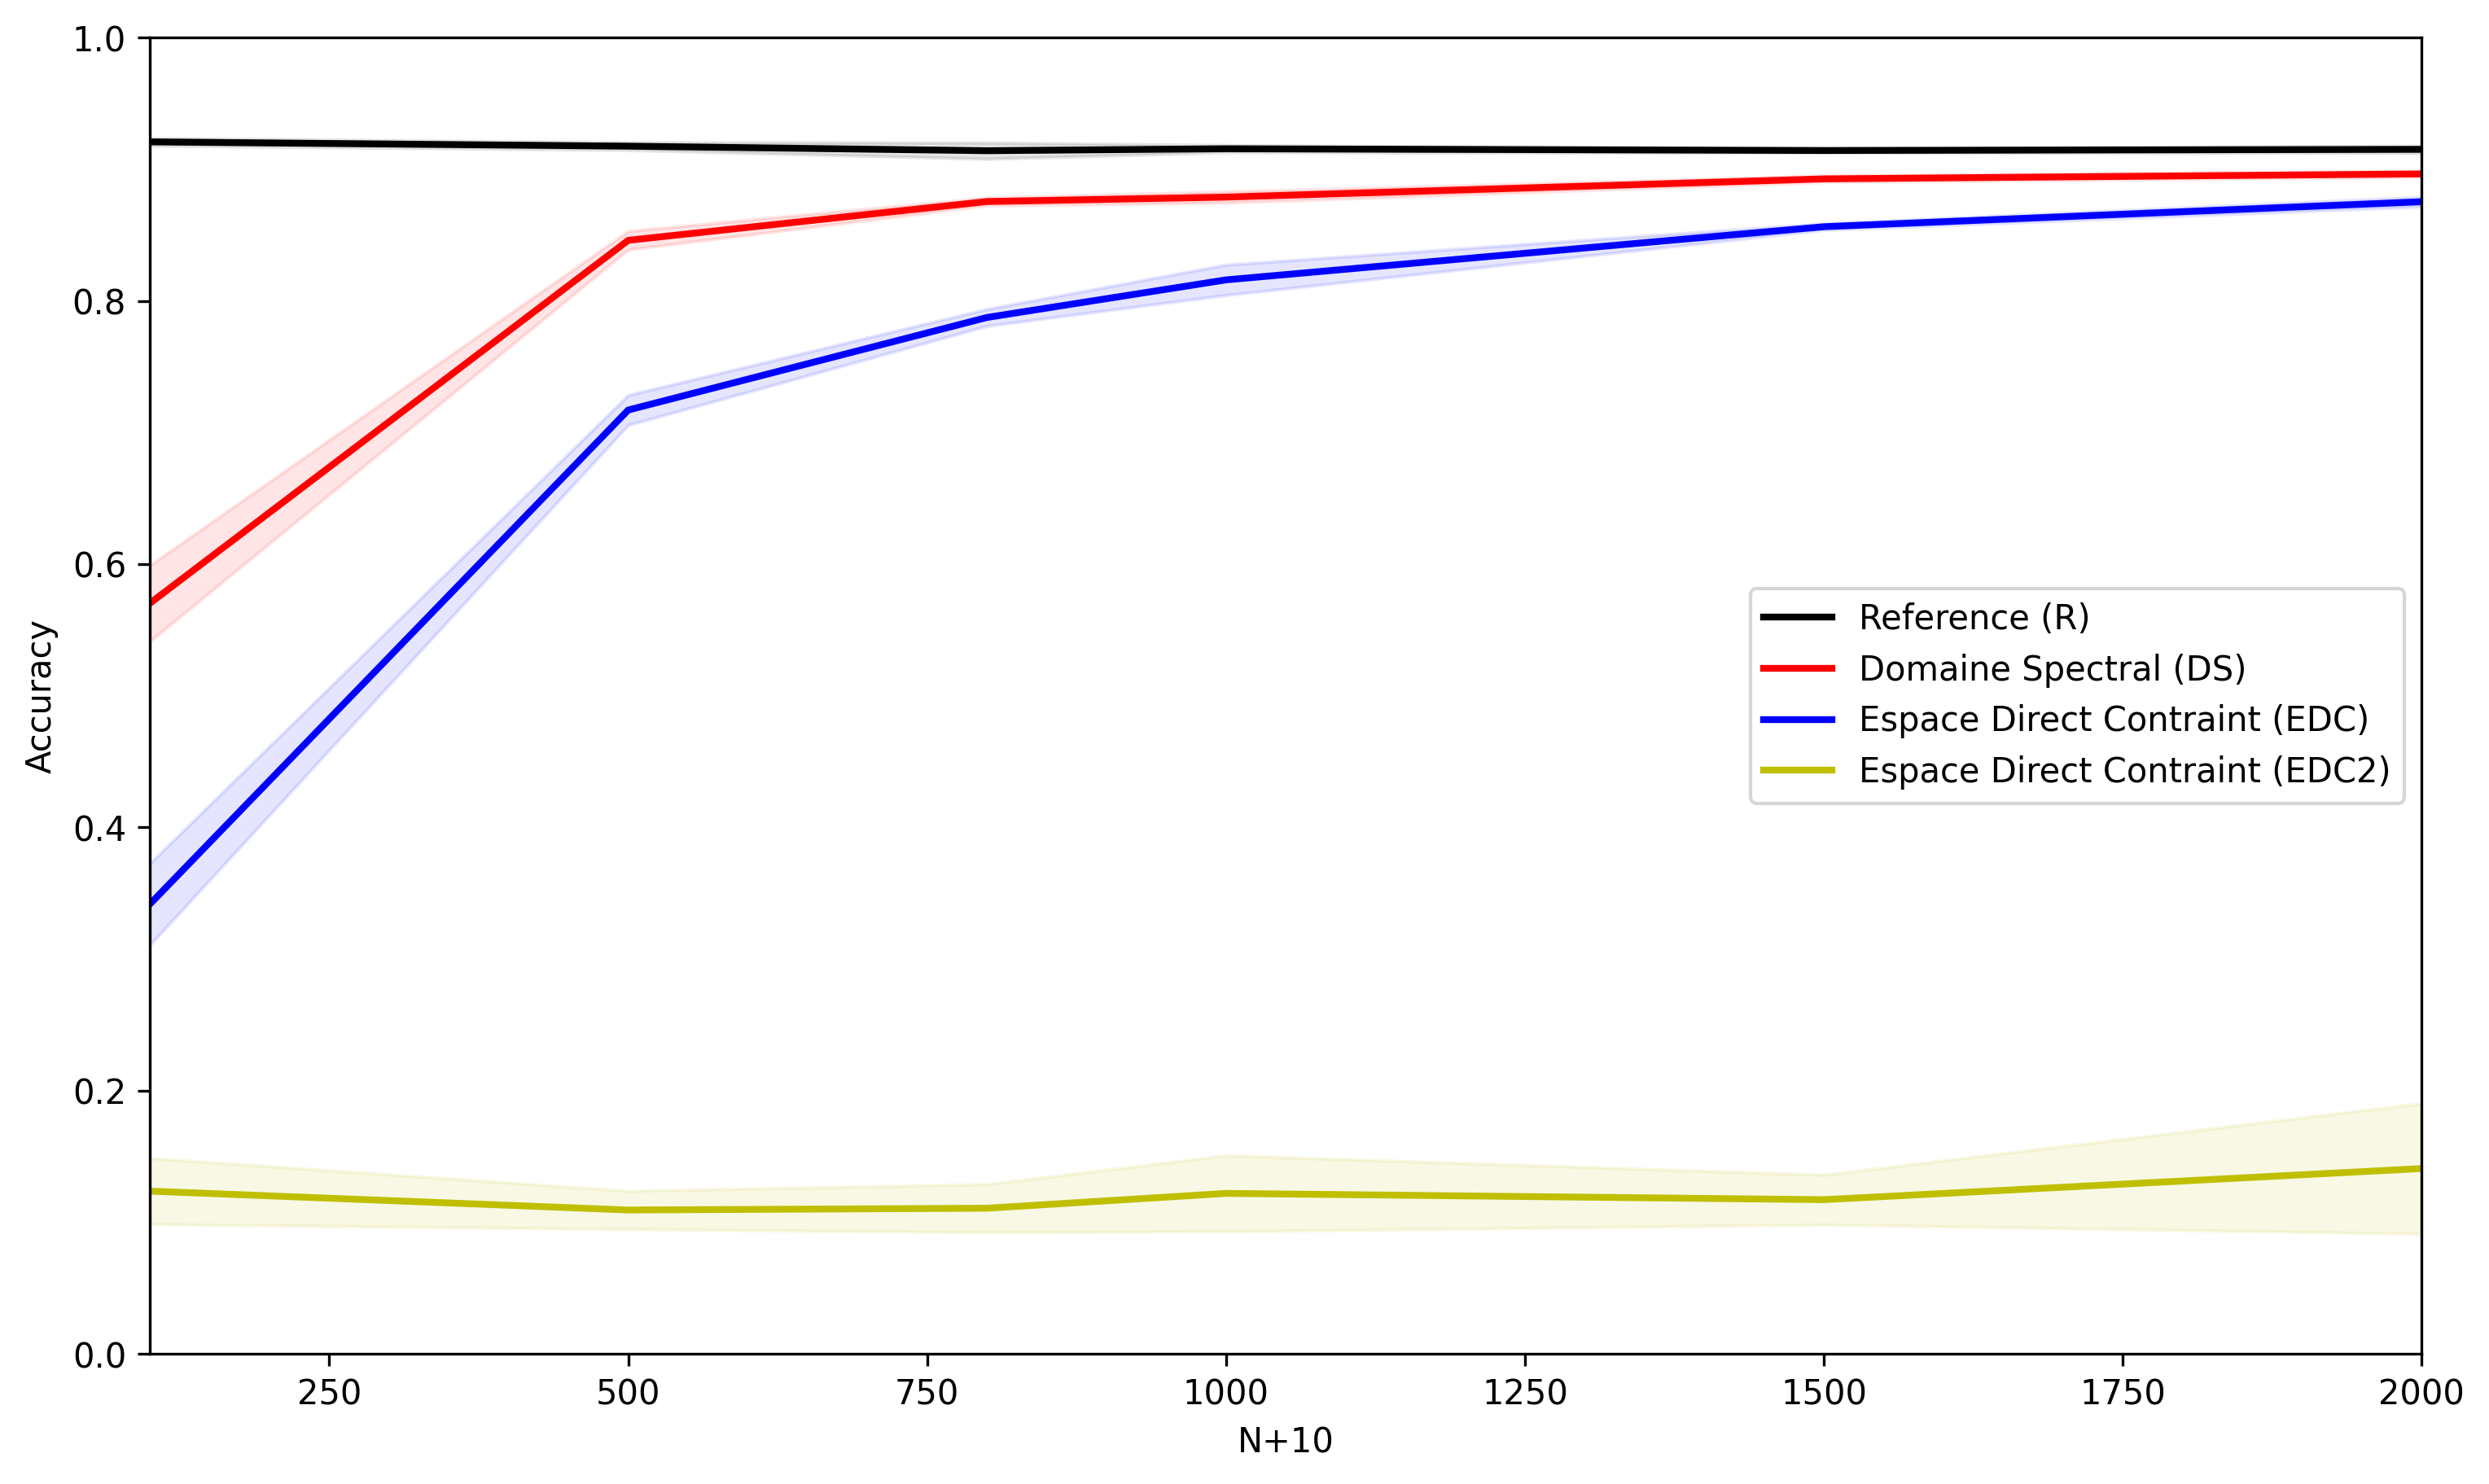

In [205]:
fig, ax = plt.subplots(num=1,figsize=(12,7),dpi=300)

ax.axis([100, 2000, 0, 1])
ax.plot(data.index, data.vmean, lw=2, label='Reference (R)', color="k")
ax.plot(data1.index, data1.vmean, lw=2, label='Domaine Spectral (DS)', color="r")
ax.plot(data2.index, data2.vmean, lw=2, label='Espace Direct Contraint (EDC)', color="b")
ax.plot(data3.index, data3.vmean, lw=2, label='Espace Direct Contraint (EDC2)', color="y")
#ax.plot(data3.index, data3.vmean, lw=2, label='SpecConv2dUseDecode', color="y")
#ax.plot(data2.index, data2.vmax, lw=2, label='DConv2dM', color="c")


ax.fill_between(data.index,data.vmean-data.sigma,data.vmean+data.sigma, color='k', alpha=0.1)
ax.fill_between(data1.index,data1.vmean+data1.sigma,data1.vmean-data1.sigma, color='r', alpha=0.1)
ax.fill_between(data2.index,data2.vmean+data2.sigma,data2.vmean-data2.sigma, color='b', alpha=0.1)
ax.fill_between(data3.index,data3.vmean+data3.sigma,data3.vmean-data3.sigma, color='y', alpha=0.1)

ax.legend(loc='center right')
ax.set_xlabel('N+10')
ax.set_ylabel('Accuracy')

In [206]:
data4=get_accuracy(name_file="spectral 2",i=0)
data4["q1"]=data4[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data4["q2"]=data4[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data4["med"]=data4[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data4

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.8366,0.8401,0.8320,0.8222,0.8279,0.8401,0.8222,0.831586,0.007059,0.8279,0.8366,0.8320
80,0.8724,0.8799,0.8731,0.8732,0.8764,0.8799,0.8724,0.875329,0.003146,0.8731,0.8764,0.8732
100,0.8832,0.8871,0.8772,0.8819,0.8774,0.8871,0.8772,0.881586,0.004172,0.8774,0.8832,0.8819
500,0.9133,0.9084,0.9061,0.9096,0.9100,0.9133,0.9061,0.909543,0.002620,0.9084,0.9100,0.9096
800,0.9146,0.9139,0.9127,0.9109,0.9132,0.9146,0.9109,0.912971,0.001405,0.9127,0.9139,0.9132
1000,0.9169,0.9174,0.9150,0.9163,0.9151,0.9174,0.9150,0.916157,0.001069,0.9151,0.9169,0.9163
1500,0.9194,0.9207,0.9177,0.9213,0.9156,0.9213,0.9156,0.918800,0.002322,0.9177,0.9207,0.9194
2000,0.9208,0.9183,0.9192,0.9214,0.9207,0.9214,0.9183,0.920014,0.001283,0.9192,0.9208,0.9207


In [207]:
data5=get_accuracy(name_file="Clustering idea",i=0)
data5["q1"]=data5[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data5["q2"]=data5[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data5["med"]=data5[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data5

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.8159,0.8068,0.7817,0.8283,0.8238,0.8283,0.7817,0.809500,0.018458,0.8068,0.8238,0.8159
80,0.8429,0.8409,0.8524,0.8467,0.8360,0.8524,0.8360,0.843900,0.006173,0.8409,0.8467,0.8429
100,0.8394,0.8477,0.8439,0.8427,0.8436,0.8477,0.8394,0.843486,0.002969,0.8427,0.8439,0.8436
500,0.8889,0.8912,0.8886,0.8960,0.8983,0.8983,0.8886,0.892843,0.004350,0.8889,0.8960,0.8912
800,0.9060,0.9030,0.9041,0.9019,0.9062,0.9062,0.9019,0.904186,0.001869,0.9030,0.9060,0.9041
1000,0.9093,0.9075,0.9066,0.9088,0.9063,0.9093,0.9063,0.907729,0.001321,0.9066,0.9088,0.9075
1500,0.9115,0.9113,0.9147,0.9107,0.9110,0.9147,0.9107,0.912086,0.001627,0.9110,0.9115,0.9113
2000,0.9136,0.9182,0.9140,0.9144,0.9153,0.9182,0.9136,0.915329,0.001844,0.9140,0.9153,0.9144


Text(0, 0.5, 'Accuracy')

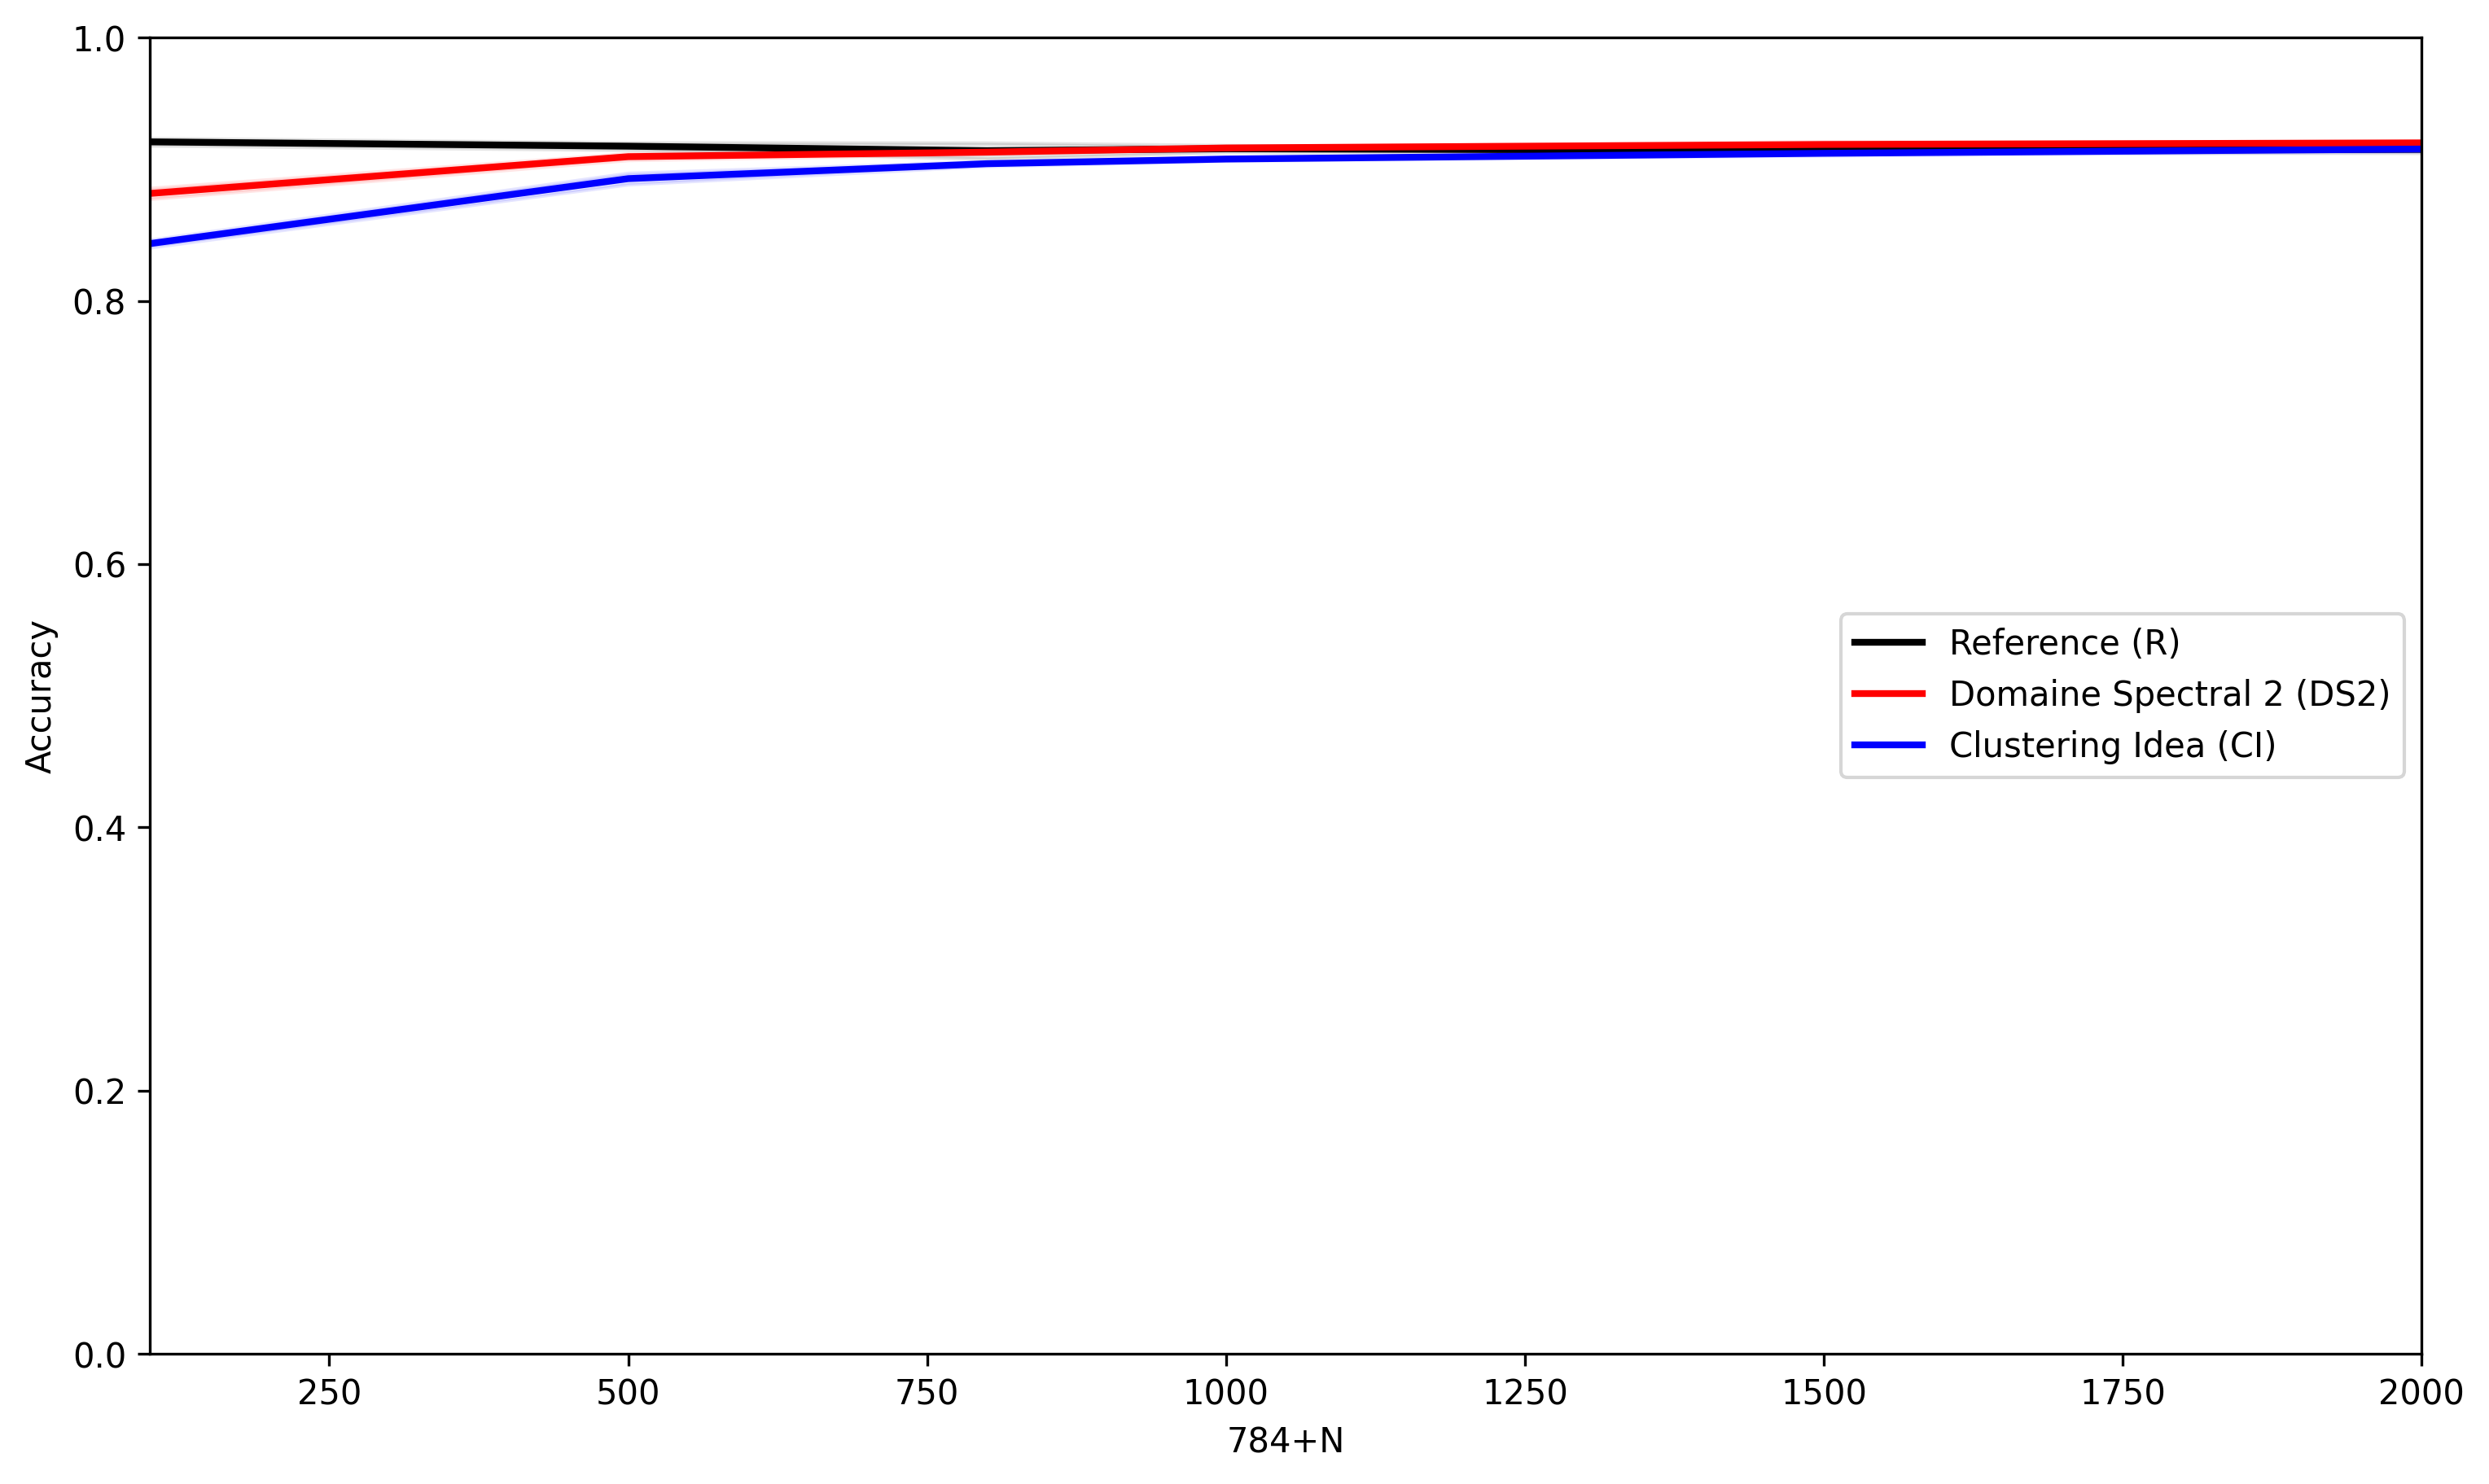

In [208]:
fig, ax = plt.subplots(num=1,figsize=(12,7),dpi=300)

ax.axis([100, 2000, 0, 1])
ax.plot(data.index, data.vmean, lw=2, label='Reference (R)', color="k")
ax.plot(data4.index, data4.vmean, lw=2, label='Domaine Spectral 2 (DS2)', color="r")
ax.plot(data5.index, data5.vmean, lw=2, label='Clustering Idea (CI)', color="b")
#ax.plot(data3.index, data3.vmean, lw=2, label='SpecConv2dUseDecode', color="y")
#ax.plot(data2.index, data2.vmax, lw=2, label='DConv2dM', color="c")


ax.fill_between(data.index,data.vmean-data.sigma,data.vmean+data.sigma, color='k', alpha=0.1)
ax.fill_between(data4.index,data4.vmean+data4.sigma,data4.vmean-data4.sigma, color='r', alpha=0.1)
ax.fill_between(data5.index,data5.vmean+data5.sigma,data5.vmean-data5.sigma, color='b', alpha=0.1)


ax.legend(loc='center right')
ax.set_xlabel('784+N')
ax.set_ylabel('Accuracy')